In [ ]:
import cv2, glob, dlib
from google.colab import drive
from google.colab.patches import cv2_imshow
import os, glob, numpy as np

drive.mount('/content/drive')

age_list = ['(0, 2)','(4, 6)','(8, 12)','(15, 20)','(25, 32)','(38, 43)','(48, 53)','(60, 100)']
gender_list = ['Male', 'Female']

age_net_url = '/content/drive/MyDrive/persona/model/age_net.caffemodel'
age_net_protourl = '/content/drive/MyDrive/persona/model/deploy_age.prototxt'

age_net = cv2.dnn.readNetFromCaffe(age_net_protourl,age_net_url)

gender_net_url = '/content/drive/MyDrive/persona/model/gender_net.caffemodel'
gender_net_protourl='/content/drive/MyDrive/persona/model/deploy_gender.prototxt'

gender_net = cv2.dnn.readNetFromCaffe(gender_net_protourl,gender_net_url)

detector=dlib.get_frontal_face_detector()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[0.9984718  0.00152822]
Male
(25, 32)


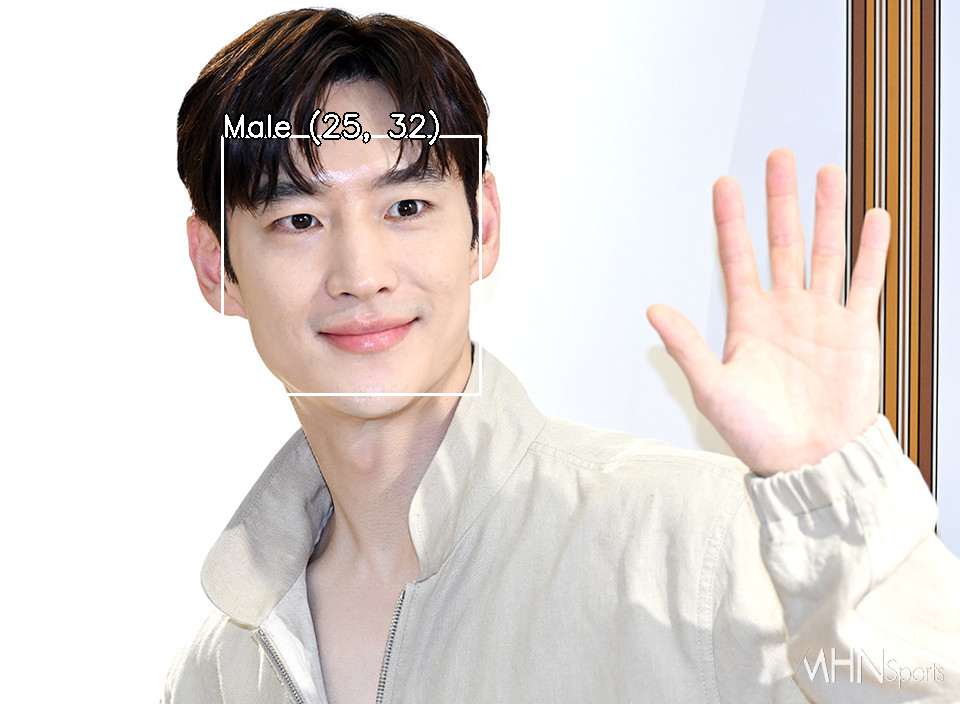

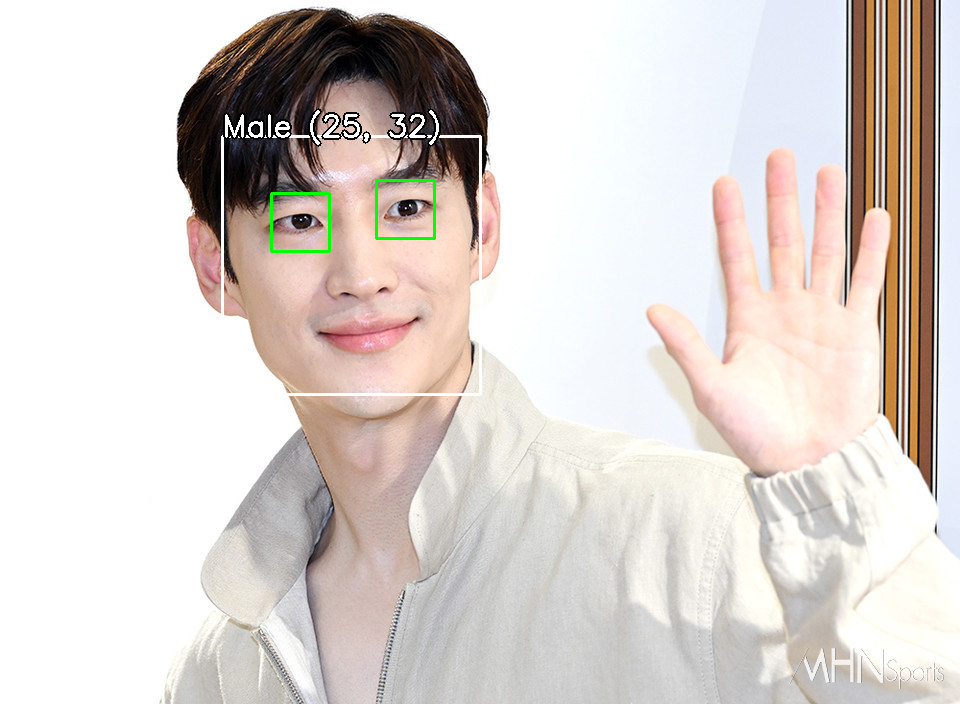

In [ ]:
img = cv2.imread('/content/drive/MyDrive/persona/img/img7.jpg')
faces = detector(img)

for face in faces:
  x1,y1,x2,y2 = face.left(),face.top(),face.right(),face.bottom()
  face_img = img[y1:y2,x1:x2].copy()
  blob = cv2.dnn.blobFromImage(face_img,scalefactor=1,size=(227,227),mean=(78.4263377603,87.7689143744,114.895847746),swapRB=False,crop=False)
  #predict gender
  gender_net.setInput(blob)
  gender_preds = gender_net.forward()
  print(gender_preds[0])
  gender = gender_list[gender_preds[0].argmax()]
  print(gender)
  #predict age
  age_net.setInput(blob)
  age_preds = age_net.forward()
  age = age_list[age_preds[0].argmax()]
  # visualize
  cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
  overlay_text = '%s %s' % (gender, age)
  cv2.putText(img, overlay_text, org=(x1, y1), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
              fontScale=1, color=(0, 0, 0), thickness=5)
  cv2.putText(img, overlay_text, org=(x1, y1),
              fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
  print(age)
cv2_imshow(img)

eyeglasses_detector = cv2.CascadeClassifier('/content/drive/MyDrive/persona/model/haarcascade_eye_tree_eyeglasses.xml')
eyeglasses_detections = eyeglasses_detector.detectMultiScale(img,scaleFactor=1.1,minNeighbors=4)

for (x, y, w, h) in eyeglasses_detections:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)



In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

X_train, X_test, y_train, y_test = np.load('/content/drive/MyDrive/persona/data/train/binary_image_data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

image_w = 64
image_h = 64
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_dir = '/content/drive/MyDrive/persona/model'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "/dog_cat_classify.model"

    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)

model.summary()

history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_split=0.15, callbacks=[checkpoint, early_stopping])
print("정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model

model_path = '/content/drive/MyDrive/persona/model/dog_cat_classify.model'  # 모델 경로 지정
model = load_model(model_path)
# 이미지 크기 조정 및 정규화
img = cv2.imread('/content/drive/MyDrive/persona/img/img7.jpg')
img = cv2.resize(img, (64, 64))
img = img.astype('float32') / 255

# 모델의 입력 형태에 맞게 차원 확장
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
print(prediction)

if prediction[0][0] > 0.525:
    print("dog")
else:
    print("cat")

1/1 [==============================] - 7s 7s/step
[[0.5355314]]
dog
